## 0.Librerías

In [34]:
import os
import pandas as pd
import time
import json

import numpy as np
from tqdm import tqdm
#from skimage.io import imread, imshow
#from skimage.transform import resize
import matplotlib.pyplot as plt
import datetime
import cv2
#Metricas
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report,ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
#%env SM_FRAMEWORK=tf.keras
# Librerias para constuir la arquitectura U-Net
from tensorflow.keras.layers import Input, Lambda, Conv2D, Dropout, MaxPooling2D, Conv2DTranspose, concatenate, MaxPool2D
from tensorflow.keras.models import Model
#import segmentation_models as sm
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf

from tensorflow.keras import backend as tf_backend
from unet_architecture import custom_Unet

In [2]:
from google.colab import drive
drive.mount('/content/drive')
# Cambia el directorio de trabajo a la carpeta deseada
os.chdir('/content/drive/MyDrive')
os.listdir()

Mounted at /content/drive


['Colab Notebooks',
 'buildings_png',
 'build_models',
 'roads_png',
 'road_models',
 'road_build_models',
 'build_models_custom',
 'Multiclass_img',
 'road_models_custom',
 'Add']

In [ ]:
os.listdir('Multiclass_img')

['classes_corrected.json', 'Img', 'Notebooks', 'unet_architecture.py']

In [3]:
from Multiclass_img.unet_architecture import custom_Unet

In [35]:
data_path_images='Multiclass_img/Img'
data_list_direc = os.listdir(data_path_images)
tipo='images'
for direc in data_list_direc:
    data_path=data_path_images+'/'+direc+'/'+tipo
    data_list_images = os.listdir(data_path)
    for file in data_list_images:
        #img=cv2.imread('../Img/Tile 1/images/image_part_001.jpg')
        print(data_path+'/'+file)

../Img/Tile 1/images/image_part_001.jpg
../Img/Tile 1/images/image_part_002.jpg
../Img/Tile 1/images/image_part_003.jpg
../Img/Tile 1/images/image_part_004.jpg
../Img/Tile 1/images/image_part_005.jpg
../Img/Tile 1/images/image_part_006.jpg
../Img/Tile 1/images/image_part_007.jpg
../Img/Tile 1/images/image_part_008.jpg
../Img/Tile 1/images/image_part_009.jpg
../Img/Tile 2/images/image_part_001.jpg
../Img/Tile 2/images/image_part_002.jpg
../Img/Tile 2/images/image_part_003.jpg
../Img/Tile 2/images/image_part_004.jpg
../Img/Tile 2/images/image_part_005.jpg
../Img/Tile 2/images/image_part_006.jpg
../Img/Tile 2/images/image_part_007.jpg
../Img/Tile 2/images/image_part_008.jpg
../Img/Tile 2/images/image_part_009.jpg
../Img/Tile 3/images/image_part_001.jpg
../Img/Tile 3/images/image_part_002.jpg
../Img/Tile 3/images/image_part_003.jpg
../Img/Tile 3/images/image_part_004.jpg
../Img/Tile 3/images/image_part_005.jpg
../Img/Tile 3/images/image_part_006.jpg
../Img/Tile 3/images/image_part_007.jpg


(644, 797, 3)


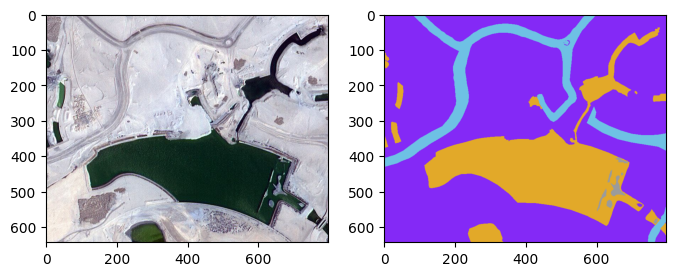

In [ ]:
img=cv2.imread(data_path_images+'/Tile 1/images/image_part_002.jpg')
img_msk=cv2.imread(data_path_images+'/Tile 1/masks/image_part_002.png')

rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
rgb_msk = cv2.cvtColor(img_msk, cv2.COLOR_BGR2RGB)
# Mostramos la imagen y su mascara asociada
print(rgb_img.shape)
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.imshow(rgb_img)
plt.subplot(1,2,2)
plt.imshow(rgb_msk)
plt.show()


In [37]:

# Cargar el archivo JSON
with open("Multiclass_img/classes_corrected.json", "r") as archivo:
    datos_json = json.load(archivo)
def from_hex2rgb(hex_color):
    # Eliminar el carácter '#' si está presente
    hex_color = hex_color.lstrip('#')
    # Convertir cada par de caracteres hexadecimales en un valor RGB
    return np.array([int(hex_color[i:i+2], 16) for i in (0, 2, 4)])
def from_rgb2bgr(color):
    return np.array([color[2],color[1],color[0]])
# Mostrar los datos cargados
dict_clases={}
i=0
for class_ in  datos_json['classes']:
    dict_clases[i]={'rgb':from_hex2rgb(class_['color']),'bgr':from_rgb2bgr(from_hex2rgb(class_['color'])),'name':class_['title'],'value':i}
    i+=1
for key in dict_clases:
    print(dict_clases[key]['name'],dict_clases[key]['rgb'],dict_clases[key]['bgr'],dict_clases[key]['value'])

Water [226 169  41] [ 41 169 226] 0
Land (unpaved area) [132  41 246] [246  41 132] 1
Road [110 193 228] [228 193 110] 2
Building [ 60  16 152] [152  16  60] 3
Vegetation [254 221  58] [ 58 221 254] 4
Unlabeled [155 155 155] [155 155 155] 5


In [ ]:
def color_to_2D_label(msk,type_='bgr'):
    """
    FUNCION: 
        Pasar de mascara recien cargada a labels/clases
    PARAMS:
        msk: np.array de tamaño (y,x,3)
        type_: tipo de transformacion de bgr o rgb
    RETURN:
        label_seg: np.array de tamaño (y,x) de labels
    """
    label_seg = np.zeros(msk.shape,dtype=np.uint8)
    for i in dict_clases:
        label_seg [np.all(msk == dict_clases[i][type_],axis=-1)] = dict_clases[i]['value']

    label_seg = label_seg[:,:,0]

    return label_seg
def label_to_color(pred_mask,type_='bgr'):
    """
    FUNCION: 
        Pasar de mascaras con clase/label asignada a color
    PARAMS:
        pred_mask: np.array de tamaño (y,x)
        type_: tipo de transformacion a bgr o rgb
    RETURN:
        label_seg: np.array de tamaño (y,x,3) de colores
    """
    label_seg = np.zeros((pred_mask.shape[0],pred_mask.shape[0],3),dtype=np.uint8)
    for i in dict_clases:
        label_seg [np.where(pred_mask == dict_clases[i]['value'])] = dict_clases[i][type_]
    return label_seg

def open_imgs(file='../Img/Tile 1/images/image_part_002.jpg',resize_=False,data_path_images=data_path_images,resize_shape=(224,224)):
    """
    FUNCION: 
        cargar las img y sus msk, ademas, aplica un resize si se quiere
        
    PARAMS:
        file: directorio donde estan las img
        resize_: bool para indicar si se hace resiza
        data_path_images: directorio donde estan las img
        resize_shape: tupla (y,x) indicando el tamño del resize

    RETURN:
        resize_img,resize_msk: np.array de las img o msk
    """
    img=cv2.imread(file)
    tile=file.split('/')[2]
    name_img=file.split('/')[-1].replace('.jpg','')
    img_msk=cv2.imread(f'{data_path_images}/{tile}/masks/{name_img}.png')
    if resize_==True:
        print('Resize aplicado')
        resize_img=cv2.resize(img,resize_shape)
        resize_msk=cv2.resize(img_msk,resize_shape)
    else:
        resize_img,resize_msk=[img,img_msk]

    return resize_img,resize_msk
def search_dir(data_path_images=data_path_images):
    """
    FUNCION: 
        obtener directorios de las img
        
    PARAMS:
        data_path_images: directorio donde estan las img

    RETURN:
        dire_end: lista con directorios de las imagenes

    """
    tiles=os.listdir(data_path_images)
    dire_end=[]
    for tile in tiles:
        dire=os.listdir(f'{data_path_images}/{tile}/images/')
        dire=[f'{data_path_images}/{tile}/images/'+file for file in dire]
        dire_end+=dire
    return dire_end
def process_img(resize_=False,resize_shape=(224,224)):
    """
    FUNCION: 
        Procesar todas las imagenes en el directorio data_path_images
        
    PARAMS:
        resize_: bool para indicar si se hace resiza
        resize_shape: tupla (y,x) indicando el tamño del resize
    RETURN:
        labels,all_img: lista si resize_=False de np.arrays de las img o msk
                        np.array si resize_=True de tamaño (numero de imagenes,resize_shape,.) de las img o msk
    """
    #buscar paths
    filenames=search_dir()
    all_img=[]
    all_msk=[]
    ############# LOOP ABRIR/RESIZE IMG #################
    for file in tqdm(filenames):
        resize_img,resize_msk=open_imgs(file=file,resize_=resize_,resize_shape=resize_shape)
        all_img.append(resize_img)
        all_msk.append(resize_msk)
    if resize_==True:
        all_img=np.array(all_img)
        all_msk=np.array(all_msk)
    ############# LOOP TRANSFORM MASK TO LABELS ##############
    labels = []
    for mask in tqdm(all_msk):
        label = color_to_2D_label(mask,type_='bgr')
        labels.append(label)
    
    if resize_==True:
        labels = np.array(labels)
        print(labels.shape,all_img.shape)
    else:
        print(len(labels),len(all_img))

    return labels,all_img
labels,all_img=process_img(resize_=False,resize_shape=(224,224))

  0%|          | 0/72 [00:00<?, ?it/s]

100%|██████████| 72/72 [00:09<00:00,  7.75it/s]

72 72


In [39]:
SMOOTH = 1e-5
def dice_multiv2(gt, pr, beta=1, num_classes=6, smooth=SMOOTH):
    """
    FUNCION: 
        Métrica de evaluacion coeficiente Dice (F1 score) para usar al entrenar modelos como metrica
    PARAMS:
        gt: Tensor ground truth (,y,x)
        pr: Tensor prediccion (,y,x,num_classes)
        beta: coeficiente para balancear precision y recall (beta=1 formula normal)
        num_classes: numero de clases a predecir
        smooth: numero para evitar divisiones por cero
    RETURN:
        Imagen y máscara recortadas.
    """


    # Convertir predicciones a clases discretas
    pr = tf_backend.argmax(pr, axis=-1)#pr(probabilidades)---> indice del mejor valor
    pr = tf_backend.one_hot(pr, num_classes=num_classes)#pr(indice del mejor valor)--->one hot
    gt = tf_backend.one_hot(tf_backend.cast(gt, tf.int32), num_classes=num_classes)
    # Convertir a float32 para evitar errores de tipo
    pr = tf_backend.cast(pr, tf.float32)
    gt = tf_backend.cast(gt, tf.float32)

    # Calcular intersección y unión (vectorizado)---> rapido
    intersection = tf_backend.sum(gt * pr, axis=[0, 1, 2])
    sum_gt = tf_backend.sum(gt, axis=[0, 1, 2])
    sum_pr = tf_backend.sum(pr, axis=[0, 1, 2])

    # Calcular TP, FP, FN
    tp = intersection #true positives
    fp = sum_pr - intersection# false positives
    fn = sum_gt - intersection# false negatives
    # F-beta score por clase (evitando divisiones por cero con smooth)
    fbeta_score_per_class = (1 + beta**2) * tp / ((1 + beta**2) * tp + beta**2 * fn + fp + smooth)

    # Promedio de todas las clases
    overall_score = tf_backend.mean(fbeta_score_per_class)
    return overall_score

In [40]:
X_train, X_temp, y_train, y_temp = train_test_split(all_img, labels, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Tamaño del conjunto de entrenamiento: {len(X_train)}")
print(f"Tamaño del conjunto de validación: {len(X_val)}")
print(f"Tamaño del conjunto de prueba: {len(X_test)}")

Tamaño del conjunto de entrenamiento: 57
Tamaño del conjunto de validación: 7
Tamaño del conjunto de prueba: 8


In [41]:
def random_crop_image_mask(image, mask, crop_size=(128, 128)):
    """
    FUNCION: 
        Realiza un recorte aleatorio sincronizado entre una imagen y su máscara.
    PARAMS:
        image: Tensor de la imagen de entrada, tamaño (x, y, 3).
        mask: Tensor de la máscara correspondiente, tamaño (x, y).
        crop_size: Tamaño del recorte (alto, ancho).
    RETURN:
        Imagen y máscara recortadas.
    """
    combined = tf.concat([image, tf.expand_dims(mask, axis=-1)], axis=-1)#combinar img y msk
    cropped_combined = tf.image.random_crop(combined, size=[crop_size[0], crop_size[1], 4])#random crop  # 3 canales + 1 de máscara
    cropped_image = cropped_combined[..., :3]
    cropped_mask = tf.squeeze(cropped_combined[..., 3:], axis=-1)
    return cropped_image, cropped_mask
def preprocess_list_with_crops(image_list, mask_list, crop_size=(128, 128),numer_crops=1):
    """
    FUNCION:
        Aplica random crops a listas de imágenes y máscaras.
    PARAMS:
        image_list: Lista de imágenes (x, y, 3).
        mask_list: Lista de máscaras (x, y).
        crop_size: Tamaño de los recortes.
        numer_crops: numero de cortes aleatorios realizados a una misma imagen
    RETURNS:
        Tensors con imágenes y máscaras recortadas.
    """
    cropped_images = []
    cropped_masks = []
    #################### LOOP IMG/MSK #####################
    for img, mask in tqdm(zip(image_list, mask_list)):
        #convertir a tensor
        img_tensor = tf.convert_to_tensor(img, dtype=tf.float32)
        mask_tensor = tf.convert_to_tensor(mask, dtype=tf.float32)
        i=0
    ################# LOOP CROPS ###########################
        while i< numer_crops:
            #realizar cortes
            cropped_img, cropped_mask = random_crop_image_mask(img_tensor, mask_tensor, crop_size)
            #añadir a las listas
            cropped_images.append(cropped_img)
            cropped_masks.append(cropped_mask)
            i+=1

    return tf.stack(cropped_images), tf.stack(cropped_masks)

# Definir tamaño del recorte
crop_size = (224, 224)
numer_crops=40
# Preprocesar datos
X_train_cropped, y_train_cropped = preprocess_list_with_crops(X_train, y_train, crop_size,numer_crops=numer_crops)
X_val_cropped, y_val_cropped = preprocess_list_with_crops(X_val, y_val, crop_size,numer_crops=numer_crops)
X_test_cropped, y_test_cropped = preprocess_list_with_crops(X_test, y_test, crop_size,numer_crops=numer_crops)

print("Tamaños después del recorte:")
print("X_train:", X_train_cropped.shape, "y_train:", y_train_cropped.shape)
print("X_val:", X_val_cropped.shape, "y_val:", y_val_cropped.shape)
print("X_test:", X_test_cropped.shape, "y_test:", y_test_cropped.shape)


57it [00:08,  6.64it/s]
7it [00:00,  9.56it/s]
8it [00:01,  7.15it/s]

Tamaños después del recorte:
X_train: (2280, 224, 224, 3) y_train: (2280, 224, 224)
X_val: (280, 224, 224, 3) y_val: (280, 224, 224)
X_test: (320, 224, 224, 3) y_test: (320, 224, 224)


In [10]:
unet_model=custom_Unet(shape=crop_size+(3,),classes=6,activation='softmax',filters=[32,64,128,256,512,256,128,64,32])
unet_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=[dice_multiv2,'accuracy'])
#unet_model.summary()

In [11]:
checkpoint = ModelCheckpoint(filepath='Multiclass_img/modelo_crop/modelo-{epoch:02d}-{val_accuracy:.2f}.weights.h5',
                             monitor='val_accuracy',  # chekeamos la val_acc
                             save_best_only=True,
                             save_weights_only=True,  # Para guardar los pesos
                             mode='max',  # para coger la mejor acc
                             verbose=1)

In [ ]:
start=time.time()
history=unet_model.fit(
   x=X_train_cropped,
   y=y_train_cropped,
   batch_size=16,
   epochs=100,
   validation_data=(X_val_cropped,y_val_cropped),
   callbacks=[checkpoint],
)
print(f'Finalizado en {round(time.time()-start,2)} s')

Epoch 1/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - accuracy: 0.5011 - dice_multiv2: 0.2080 - loss: 2.6670
Epoch 1: val_accuracy improved from -inf to 0.50660, saving model to Multiclass_img/modelo_crop/modelo-01-0.51.weights.h5
143/143 ━━━━━━━━━━━━━━━━━━━━ 110s 504ms/step - accuracy: 0.5017 - dice_multiv2: 0.2084 - loss: 2.6588 - val_accuracy: 0.5066 - val_dice_multiv2: 0.2251 - val_loss: 1.2484
Epoch 2/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.7063 - dice_multiv2: 0.3826 - loss: 0.8681
Epoch 2: val_accuracy improved from 0.50660 to 0.61458, saving model to Multiclass_img/modelo_crop/modelo-02-0.61.weights.h5
143/143 ━━━━━━━━━━━━━━━━━━━━ 38s 269ms/step - accuracy: 0.7064 - dice_multiv2: 0.3829 - loss: 0.8677 - val_accuracy: 0.6146 - val_dice_multiv2: 0.3205 - val_loss: 1.0304
Epoch 3/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.7667 - dice_multiv2: 0.5100 - loss: 0.6908
Epoch 3: val_accuracy improved from 0.61458 to 0.69870, saving model to Mult

In [ ]:
unet_model.save_weights('Multiclass_img/modelo_resize/model_final.weights.h5')

In [48]:
preds=unet_model.predict(X_test_cropped[:])
dice_test=dice_multiv2(y_test_cropped,preds)
print('DICE test:',dice_test.numpy(),' ACC',np.mean(np.argmax(preds, axis=-1)==y_test_cropped))

10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 939ms/step
DICE test: 0.6950101  ACC 0.8764308384486608


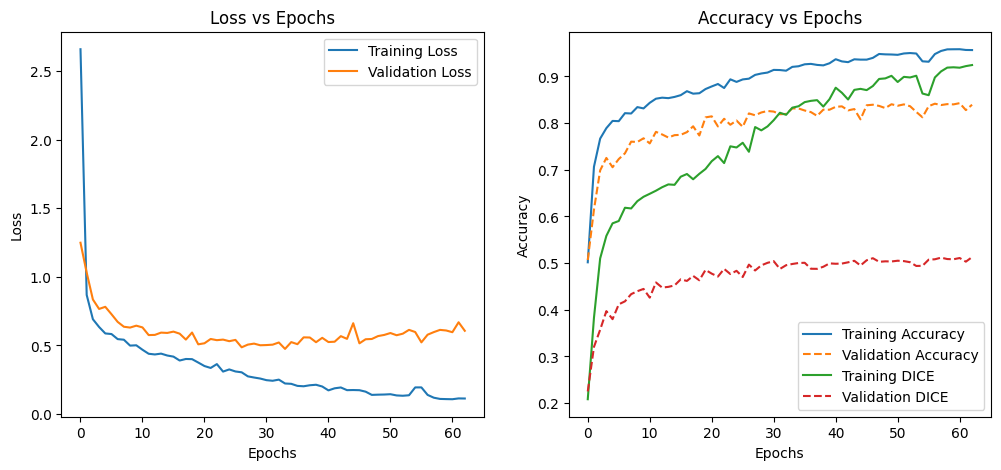

In [32]:
# Obtener los datos de 'loss' y 'accuracy' del objeto history
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history.get('accuracy')  # 'accuracy' es la métrica de precisión
val_accuracy = history.history.get('val_accuracy')  # Precisión en validación
dice=history.history.get('dice_multiv2')
val_dice=history.history.get('val_dice_multiv2')
# Crear el gráfico de Loss vs Epochs
plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy',linestyle='--')
plt.plot(dice, label='Training DICE')
plt.plot(val_dice, label='Validation DICE',linestyle='--')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


# Mostrar los gráficos
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


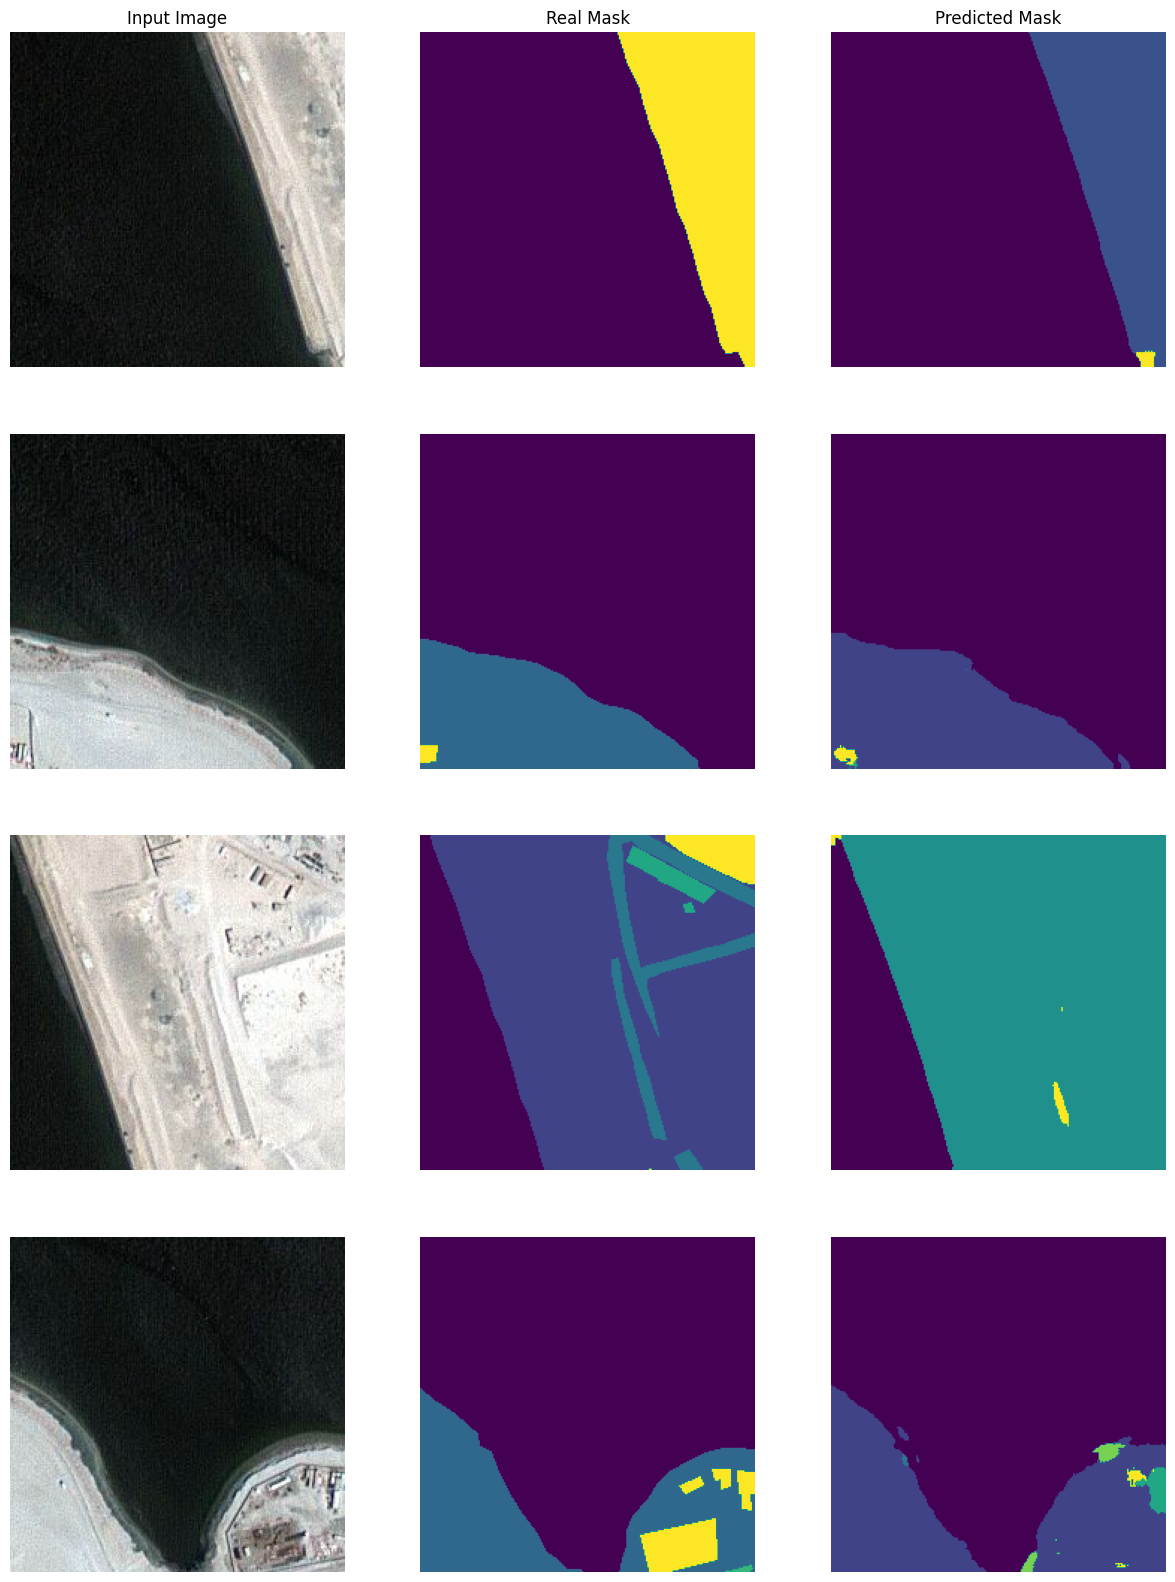

In [58]:
def plot_images_comparation(list_images_rows,titles_rows=["Input Image", "Real Mask", "Predicted Mask"]):
    """
    FUNCION:    Plot comparativo de Img real, mascara y prediccion

    PARAMS:
        list_images_rows: lista de listas que contienen las imagenes [[img,msk,pred],[...],...]
        titles_rows: [] titulos de las imagenes

    RETURN:
        PLOT

    """
    num_rows = len(list_images_rows)
    fig=plt.figure(figsize=(15, 5*num_rows))
    index=1
    for i in range(num_rows):
        for j in range(3):
            plt.subplot(num_rows,3,index)
            plt.imshow(list_images_rows[i][j])
            plt.axis('off')
            if i==0:
                plt.title(titles_rows[j])
            index+=1
    plt.show()

# Índices de las imágenes que deseas mostrar agrupadas
max_image=4
# Preparar imágenes y títulos para visualizar en grupos de tres
images_list = []
preds=unet_model.predict(X_train_cropped[:4])
#pred_binary = (preds > 0.5).astype(np.uint8)
preds_label = np.argmax(preds, axis=-1)
# Agrupar imágenes y títulos en filas de tres
for i in range(0, 4):
    input_image = X_train_cropped[i]
    ground_truth_mask = y_train_cropped[i]
    predicted_mask = preds_label[i]
    images_list.append([input_image/255, ground_truth_mask, predicted_mask])
plot_images_comparation(images_list)


# Reconstruccion de imagenes

In [56]:
def reconstruir_imagen(trozos_imagen,tamano_original,tipo='img'):
    """
    FUNCION: Reconstruir una imagen orginal de tamaño (tamaño original(y,x))  a partir de sus cortes de tamaño (cut,cut)  

    PARAMS:
        trozos_imagen: np.array de los cortes (numero de cortes,cut,cut,channel)
        tamaño_original: tupla indicando el tamño de x e y originales
        type: indica si es una imagen o su mascara (msk), las mascaras no tienen la shape adicional de channel y las imagenes si

    RETURN:
        recon_img: np.array(y,x,channels) imgen reconstruida

    """
    cut=trozos_imagen.shape[1]#obtener tamaño d elos cortes
    shape_original_y,shape_original_x=tamano_original#obtener tamño de la imagen original
    num_cuts_eje_x=(shape_original_x//cut)+1#obtener numero de cortes realizados en el eje x
    num_cuts_eje_y=(shape_original_y//cut)+1#obtener numero de cortes realizados en el eje y
    recon_img=np.array([])
    ##################### ASIGNAR TAMAÑO A IMAGEN FINAL ##################
    if tipo == 'img':
        channels=trozos_imagen.shape[3]
        recon_img=np.zeros((shape_original_y,shape_original_x,channels))
    elif tipo=='msk':
        if len(trozos_imagen.shape)==3:
            recon_img=np.zeros((shape_original_y,shape_original_x))
        elif len(trozos_imagen.shape)==4:
            recon_img=np.zeros((shape_original_y,shape_original_x,1))
    index_tot=0
    #####################   LOOP EJE x ######################
    for i in range(num_cuts_eje_x):
        if i!=num_cuts_eje_x-1:
            cut_ini_x=(i)*cut  #corte inicial
            cut_fin_x=(i+1)*cut#corte final
        # PARA EL DESFASE DEL ULTIMO CORTE
        else:
            cut_ini_x=shape_original_x-cut
            cut_fin_x=shape_original_x
    #####################   LOOP EJE y ######################
        for j in range(num_cuts_eje_y):
            if j!=num_cuts_eje_y-1:
                cut_ini_y=(j)*cut#corte inicial
                cut_fin_y=(j+1)*cut#corte final
            # PARA EL DESFASE DEL ULTIMO CORTE
            else:
                cut_ini_y=shape_original_y-cut
                cut_fin_y=shape_original_y
    #####################   RECONSTRUIR IMAGEN ######################
            if tipo == 'img':
                recon_img[cut_ini_y:cut_fin_y,cut_ini_x:cut_fin_x,:]=trozos_imagen[index_tot]
            elif tipo=='msk':
                if len(trozos_imagen.shape)==3:
                    recon_img[cut_ini_y:cut_fin_y,cut_ini_x:cut_fin_x]=trozos_imagen[index_tot]
                if len(trozos_imagen.shape)==4:
                    recon_img[cut_ini_y:cut_fin_y,cut_ini_x:cut_fin_x,:]=trozos_imagen[index_tot]

            index_tot+=1
    return recon_img
def obtener_corte(img,cut=224,tipo='img'):
    """
    FUNCION:    Obtener cortes de una imagen dada de un tamaño (cutxcut)

    PARAMS:
        img: np.array de la imagen por cv2.imread()
        cut: tamaño del corte
        type: indica si es una imagen o su mascara (msk)

    RETURN:
        array_tot: np.array(numero_cortes,cut,cut,canales) donde canales son 3 en las imagenes
        normales y nada en las mascaras

    """
    # Obtener las dimensiones de la imagen (height, width, channels)
    if tipo == 'img':
        height, width, channels = img.shape
        format=(1,cut,cut,channels)
    elif tipo == 'msk':
        height, width= img.shape
        format=(1,cut,cut)

    # Definir las coordenadas para el recorte
    max_val_cut_y=height-cut
    max_val_cut_x=width-cut
    array_tot=np.array([])
    ######################## LOOP EJE X #####################
    for j in range(1,int(width/cut)+2):
        if cut*j<width:
            cut_ini_x=cut*(j-1)#corte inicial
            cut_fin_x=cut*j#corte final
        # PARA EL DESFASE DEL ULTIMO CORTE
        else:
            cut_ini_x=max_val_cut_x
            cut_fin_x=width
    ########################### LOOP EJE Y ################
        for i in range(1,int(height/cut)+2):
            if cut*i<height:
                cut_ini=cut*(i-1)#corte inicial
                cut_fin=cut*i#corte final
            # PARA EL DESFASE DEL ULTIMO CORTE
            else:
                cut_ini=max_val_cut_y
                cut_fin=height
    #####################   REALIZAR CORTES ######################
            if tipo == 'img':
                cut_img = img[cut_ini:cut_fin, cut_ini_x:cut_fin_x,:]
            elif tipo == 'msk':
                cut_img = img[cut_ini:cut_fin, cut_ini_x:cut_fin_x]
            #agrupar imagenes en un mismo array
            if array_tot.shape[0]>0:
                array_tot=np.vstack([array_tot,cut_img.reshape(format)])
            else:
                array_tot=cut_img.reshape(format)
    return array_tot
def plot_images_comparation(list_images_rows,titles_rows=["Input Image", "Real Mask", "Predicted Mask"]):
    """
    FUNCION:    Plot comparativo de Img real, mascara y prediccion

    PARAMS:
        list_images_rows: lista de listas que contienen las imagenes [[img,msk,pred],[...],...]
        titles_rows: [] titulos de las imagenes

    RETURN:
        PLOT

    """
    num_rows = len(list_images_rows)
    fig=plt.figure(figsize=(15, 5*num_rows))
    index=1
    for i in range(num_rows):
        for j in range(3):
            plt.subplot(num_rows,3,index)
            plt.imshow(list_images_rows[i][j])
            plt.axis('off')
            if i==0:
                plt.title(titles_rows[j])
            index+=1
    plt.show()

shape (1479, 2149, 3)
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 659ms/step


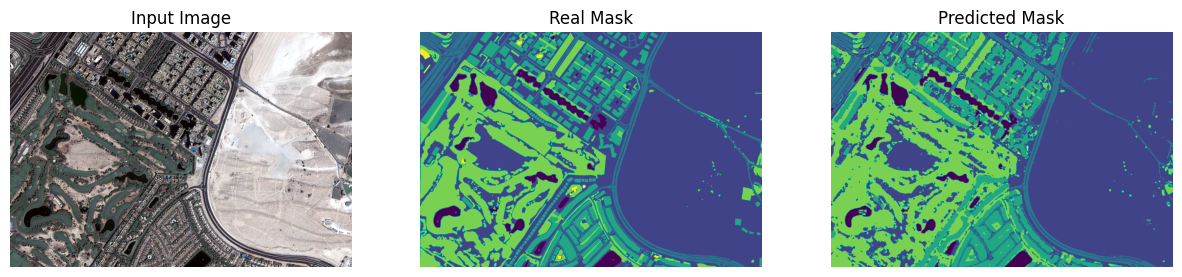

Accuracy 0.8480819262446077 : DICE 0.8480819463729858


In [57]:
model_load=custom_Unet(shape=crop_size+(3,),classes=6,activation='softmax',filters=[32,64,128,256,512,256,128,64,32])
model_load.load_weights('../modelo-20-0.81.weights.h5')

img=cv2.imread(data_path_images+'/Tile 8/images/image_part_001.jpg')
img_msk=cv2.imread(data_path_images+'/Tile 8/masks/image_part_001.png')
print(f'shape {img.shape}')
#realizar corte
trozos_imagen=obtener_corte(img)
#predicciones
preds=model_load.predict(trozos_imagen)
#reconstruyo la prediccion
pred_mask_recon=reconstruir_imagen(preds,(img.shape[0],img.shape[1]),tipo='img')
# Mostrar las imágenes en filas de tres
pred_binary=np.argmax(pred_mask_recon,axis=-1)
plot_images_comparation([[img,color_to_2D_label(img_msk,type_='bgr'),pred_binary]])
print(f'Accuracy {accuracy_score(color_to_2D_label(img_msk).flatten(),pred_binary.flatten())} : DICE {dice_multiv2(color_to_2D_label(img_msk),pred_mask_recon).numpy()}')